In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

In [16]:
# Load the CSV files
ev_file_path = 'data/alt_fuel_stations.csv'
filtered_ev_file_path = 'data/filtered_alt_fuel_stations.csv'
sdge_file_path = 'data/SDGE-ELEC-2024-Q3.csv'
# sdge_file_2023_q1 =  'SDGE-ELEC-2023-Q1.csv'
# sdge_file_2023_q2 =  'SDGE-ELEC-2023-Q2.csv'
# sdge_file_2023_q3 =  'SDGE-ELEC-2023-Q3.csv'
# sdge_file_2023_q4 =  'SDGE-ELEC-2023-Q4.csv'



In [17]:
ev_chargers_df = pd.read_csv(ev_file_path)
ev_chargers_in_sdge_area = pd.read_csv(filtered_ev_file_path)
sdge_data_df = pd.read_csv(sdge_file_path)

/var/folders/xc/6jdw4jhn5_79w695j45v4rtr0000gn/T/ipykernel_90373/3538070483.py:1: DtypeWarning: Columns (6,20,31,46,73) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_chargers_df = pd.read_csv(ev_file_path)


In [18]:
san_diego_df = ev_chargers_df[ev_chargers_df['City'] == 'San Diego']


In [19]:
num_ev_chargers_in_sd_area = san_diego_df.shape[0]

# Display the result
print(f'The number of EV chargers in the San Diego service area is: {num_ev_chargers_in_sd_area}')


The number of EV chargers in the San Diego service area is: 850


In [9]:
# Convert 'Open Date' to datetime and extract the year
ev_chargers_df['Open Date'] = pd.to_datetime(ev_chargers_df['Open Date'], errors='coerce')  # Convert to datetime, errors as NaT
ev_chargers_df['Open Year'] = ev_chargers_df['Open Date'].dt.year  # Extract the year

# Group by year to count the number of stations opened each year
stations_per_year = ev_chargers_df.groupby('Open Year').size().reset_index(name='Number of Stations Opened')

In [10]:
stations_per_year

,Open Year,Number of Stations Opened
0,1995.0,1
1,1997.0,6
2,1998.0,14
3,1999.0,12
4,2000.0,3
5,2002.0,16
6,2004.0,14
7,2005.0,3
8,2006.0,3
9,2008.0,14


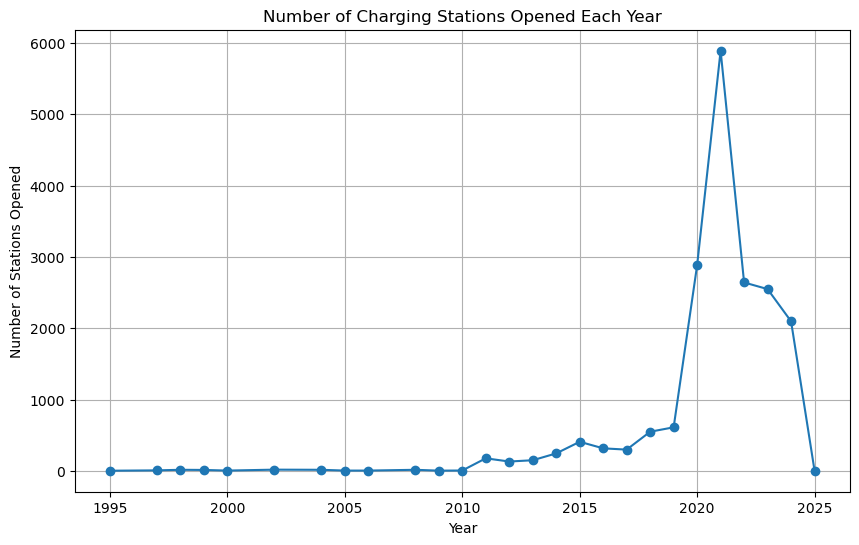

In [11]:
# Plot the time series of stations opened each year
plt.figure(figsize=(10, 6))
plt.plot(stations_per_year['Open Year'], stations_per_year['Number of Stations Opened'], marker='o')
plt.title('Number of Charging Stations Opened Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Stations Opened')
plt.grid(True)
plt.show()


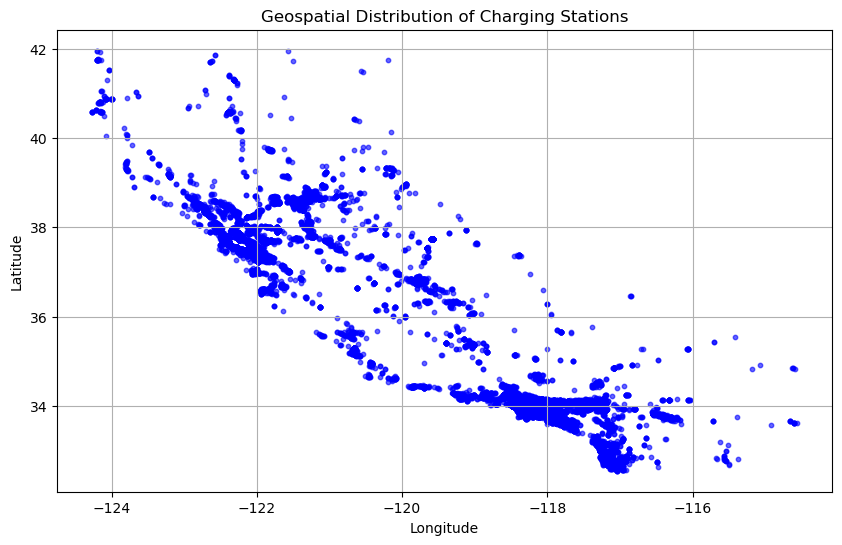

In [12]:
# Geospatial plot: using Latitude and Longitude columns
# Clean the data to remove rows with missing or non-numeric values in Latitude and Longitude

ev_chargers_df_geo_clean = ev_chargers_df.dropna(subset=['Latitude', 'Longitude']).copy()  # Make an explicit copy
ev_chargers_df_geo_clean.loc[:, 'Latitude'] = pd.to_numeric(ev_chargers_df_geo_clean['Latitude'], errors='coerce')
ev_chargers_df_geo_clean.loc[:, 'Longitude'] = pd.to_numeric(ev_chargers_df_geo_clean['Longitude'], errors='coerce')

# Simple scatter plot of geospatial data
plt.figure(figsize=(10, 6))
plt.scatter(ev_chargers_df_geo_clean['Longitude'], ev_chargers_df_geo_clean['Latitude'], c='blue', alpha=0.6, s=10)
plt.title('Geospatial Distribution of Charging Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [20]:
# Re-import necessary libraries in case of environment reset

# Load the dataset again
alt_fuel_stations = ev_chargers_in_sdge_area

# Filter out rows with non-numeric Latitude and Longitude values
alt_fuel_stations_clean = alt_fuel_stations[pd.to_numeric(alt_fuel_stations['latitude'], errors='coerce').notnull() & 
                                            pd.to_numeric(alt_fuel_stations['longitude'], errors='coerce').notnull()]

# Convert Latitude and Longitude columns to numeric
alt_fuel_stations_clean['latitude'] = pd.to_numeric(alt_fuel_stations_clean['latitude'])
alt_fuel_stations_clean['longitude'] = pd.to_numeric(alt_fuel_stations_clean['longitude'])

# Create a GeoDataFrame for all EV charging stations
all_ev_stations_gdf = gpd.GeoDataFrame(
    alt_fuel_stations_clean,
    geometry=gpd.points_from_xy(alt_fuel_stations_clean.longitude, alt_fuel_stations_clean.latitude),
    crs="EPSG:4326"
)

# Plotting all EV charging stations using Folium
all_ev_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)
for _, row in all_ev_stations_gdf.iterrows():
    popup_text = f"""
    <b>Station Name:</b> {row['station_name']}<br>
    <b>Street Address:</b> {row['street_address']}<br>
    <b>City:</b> {row['city']}<br>
    <b>ZIP Code:</b> {row['zip']}<br>
    <b>Fuel Type:</b> {row['fuel_type_code']}<br>
    <b>EV Network:</b> {row['ev_network']}<br>
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(all_ev_map)


# Save and display map for all EV charging stations
all_ev_map.save('Interactive_output/all_ev_stations_map.html')
all_ev_map
